# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Análise Estatística Para Data Science com Linguagem Python</font>

## <font color='blue'>Mini-Projeto 4</font>
### <font color='blue'>Forecast de Séries Temporais Para Previsão de Vendas</font>

![DSA](imagens/MP4.png)

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.18


In [ ]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
# !pip install -q -U watermark

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

statsmodels: 0.14.1
seaborn    : 0.13.2
numpy      : 1.26.4
pandas     : 2.0.3
matplotlib : 3.8.2



## Carregando e Explorando os Dados

In [4]:
# Carregando o DataFrame a partir do arquivo CSV
df_dsa = pd.read_csv('dados/vendas.csv')

In [5]:
df_dsa.shape

(48, 2)

In [6]:
df_dsa.head()

,mes,vendas
0,1,65.820262
1,2,64.661040
2,3,70.893690
3,4,77.864720
4,5,74.337790


In [7]:
df_dsa.tail()

,mes,vendas
43,44,139.093623
44,45,127.451739
45,46,131.149374
46,47,132.736023
47,48,149.887452


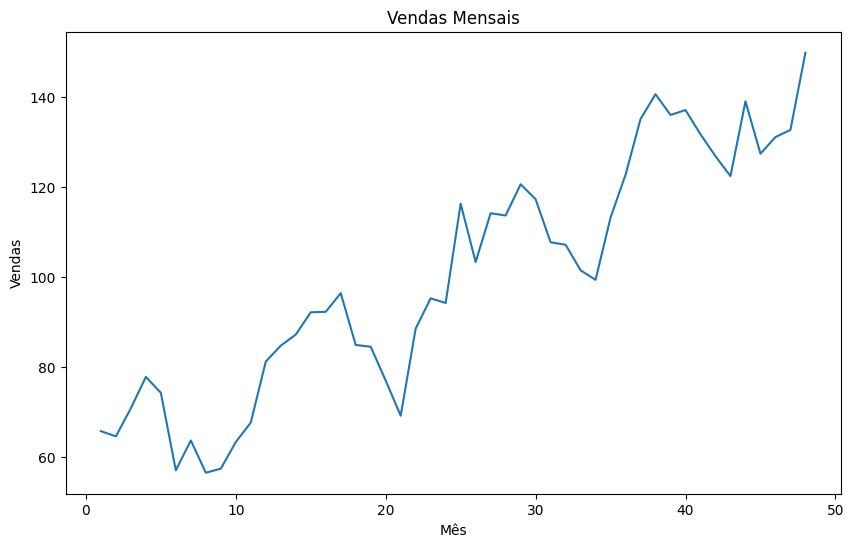

In [9]:
# Plotando os dados
plt.figure(figsize=(10, 6))
plt.plot(df_dsa['mes'], df_dsa['vendas'])
plt.title('Vendas Mensais')
plt.xlabel('Mês')
plt.ylabel('Vendas')
plt.show()

## Análise Univariada

In [11]:
# Resumo estatístico
df_dsa.vendas.describe()

count     48.000000
mean      99.922354
std       26.683526
min       56.582960
25%       77.665857
50%       97.953079
75%      122.546923
max      149.887452
Name: vendas, dtype: float64

In [12]:
# Verificando valores ausentes
df_dsa.isnull().sum()

mes       0
vendas    0
dtype: int64

<Axes: ylabel='vendas'>

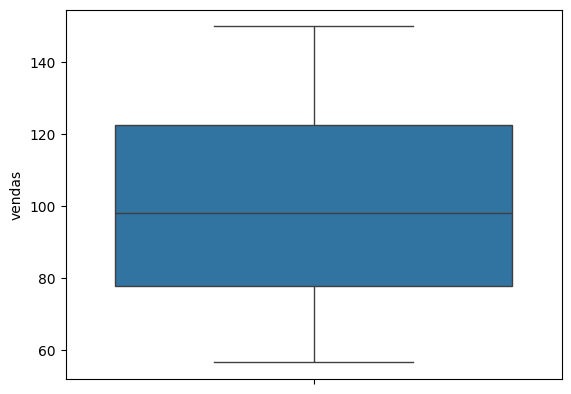

In [13]:
# Verificando outliers
sns.boxplot(df_dsa["vendas"])

## Decomposição da Série Temporal

A decomposição de séries temporais é uma técnica estatística que divide uma série temporal em componentes distintos, como tendência, sazonalidade e ruído. Essa abordagem oferece vários benefícios práticos e analíticos:

**Facilita a Análise**: A decomposição permite uma melhor compreensão da estrutura dos dados. Ao dividir a série temporal em componentes mais simples, é mais fácil analisar e interpretar o comportamento da série.

**Modelagem e Previsão**: A decomposição pode simplificar o processo de modelagem ao permitir que cada componente seja modelado separadamente. Isso pode resultar em modelos mais precisos.

**Identificação de Padrões**: A análise de cada componente isolado pode ajudar a identificar padrões, como ciclos sazonais ou tendências de longo prazo, que podem não ser imediatamente aparentes nos dados brutos.

**Simulação e Cenários Futuros**: Compreender os componentes individuais permite simular diferentes cenários, como o que poderia acontecer se a tendência ou sazonalidade mudassem.

**Melhor Planejamento e Tomada de Decisão**: Em aplicações empresariais, entender a sazonalidade e a tendência pode ajudar na alocação eficaz de recursos. Por exemplo, um negócio de varejo pode se preparar melhor para períodos de alta demanda se entender sua sazonalidade.

In [14]:
# Decomposição
decomposition = seasonal_decompose(df_dsa['vendas'], model = 'additive', period = 12)

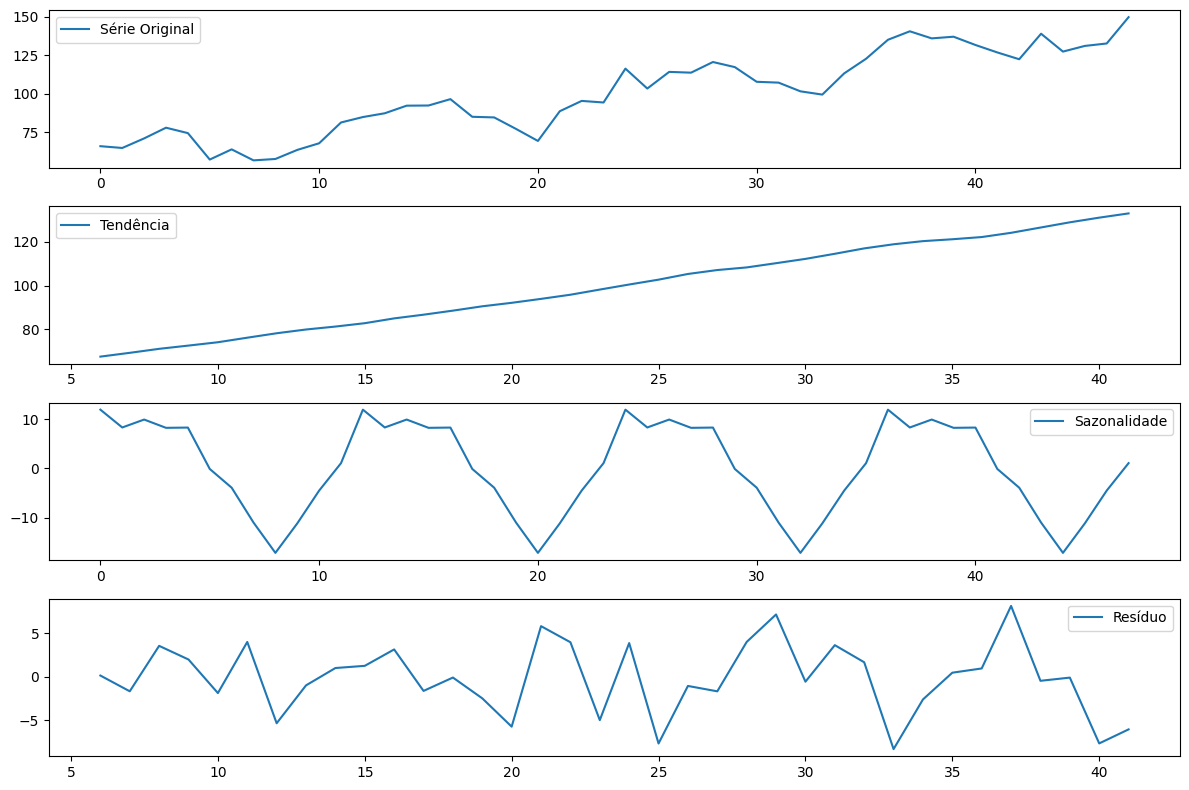

In [15]:
# Plotando os componentes
plt.figure(figsize = (12, 8))

plt.subplot(411)
plt.plot(df_dsa['vendas'], label = 'Série Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(decomposition.trend, label = 'Tendência')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(decomposition.seasonal, label = 'Sazonalidade')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(decomposition.resid, label = 'Resíduo')
plt.legend(loc='best')

plt.tight_layout()

## Testando a Estacionaridade

Estacionariedade é uma propriedade importante em séries temporais que indica que as propriedades estatísticas da série não mudam com o tempo. Em uma série temporal estacionária, parâmetros como a média, a variância e a estrutura de autocorrelação são constantes ao longo do tempo. Isso significa que o comportamento geral da série permanece o mesmo, independentemente do ponto temporal em que você se encontra.

A estacionariedade é uma suposição fundamental em muitos modelos de séries temporais, como ARIMA e suas variações. Uma série temporal que não é estacionária pode muitas vezes ser transformada em uma que é, através de métodos como diferenciação, transformações logarítmicas ou outros métodos matemáticos.

Existem várias formas de testar a estacionariedade de uma série temporal, incluindo testes estatísticos como o teste Dickey-Fuller Aumentado e exames visuais de gráficos de séries temporais e suas funções de autocorrelação e autocorrelação parcial.

In [16]:
# Função para executar o Teste de Dickey-Fuller
def testa_estacionaridade(timeseries):
    
    print('Resultados do Teste de Dickey-Fuller:')
    
    dftest = adfuller(timeseries, autolag = 'AIC')
    
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic',
                                               'p-value',
                                               '#Lags Usados',
                                               'Número de Observações Usadas'])
    
    for key, value in dftest[4].items():
        dfoutput['Valor Crítico (%s)' % key] = value
        
    print(dfoutput)

In [17]:
# Executando o Teste de Dickey-Fuller
testa_estacionaridade(df_dsa['vendas'])

Resultados do Teste de Dickey-Fuller:
Test Statistic                  -0.239381
p-value                          0.933662
#Lags Usados                    10.000000
Número de Observações Usadas    37.000000
Valor Crítico (1%)              -3.620918
Valor Crítico (5%)              -2.943539
Valor Crítico (10%)             -2.610400
dtype: float64


O valor-p é alto. A série não é estacionária. Vamos aplicar uma diferenciação.

In [19]:
# Diferenciação
df_dsa['vendas_diff'] = df_dsa['vendas'].diff()

In [20]:
df_dsa.head()

,mes,vendas,vendas_diff
0,1,65.820262,NaN
1,2,64.661040,-1.159222
2,3,70.893690,6.232650
3,4,77.864720,6.971030
4,5,74.337790,-3.526930


In [21]:
# Dropna de valores ausentes
df_dsa.dropna(subset=['vendas_diff'], inplace=True)

In [22]:
df_dsa.head()

,mes,vendas,vendas_diff
1,2,64.661040,-1.159222
2,3,70.893690,6.232650
3,4,77.864720,6.971030
4,5,74.337790,-3.526930
5,6,57.113611,-17.224179


In [23]:
# Executando o Teste de Dickey-Fuller
testa_estacionaridade(df_dsa['vendas_diff'])

Resultados do Teste de Dickey-Fuller:
Test Statistic                 -6.343112e+00
p-value                         2.723929e-08
#Lags Usados                    1.000000e+01
Número de Observações Usadas    3.600000e+01
Valor Crítico (1%)             -3.626652e+00
Valor Crítico (5%)             -2.945951e+00
Valor Crítico (10%)            -2.611671e+00
dtype: float64


O valor-p é muito baixo. A série é estacionária. Podemos seguir para a modelagem.

Criaremos diversos modelos e vamos compará-los usando a mesma métrica, o AIC. 

O Critério de Informação de Akaike (AIC, do inglês Akaike Information Criterion) é uma métrica usada para avaliar a qualidade de um modelo estatístico. Ele fornece uma medida relativa de quão bem o modelo ajusta os dados, ao mesmo tempo em que penaliza modelos mais complexos que incluem mais parâmetros. O AIC busca encontrar o equilíbrio entre a adequação do modelo aos dados e a complexidade do modelo, ajudando a evitar o sobreajuste.

O objetivo ao usar o AIC é geralmente **encontrar o modelo que tenha o menor valor de AIC possível**, indicando um bom ajuste aos dados com uma penalidade mínima por complexidade. É comumente utilizado na seleção de modelos, incluindo modelos de séries temporais como ARIMA e SARIMA, onde várias combinações de parâmetros são possíveis e o AIC pode ajudar a identificar qual combinação é mais apropriada.

## Modelo AR (AutoRegressive)

O modelo AutoRegressivo (AR) é um tipo de modelo de séries temporais que utiliza valores passados da série para prever valores futuros. 

Em outras palavras, o valor atual de uma série temporal é considerado como uma combinação linear dos valores anteriores. 

Este modelo é particularmente útil para séries temporais que mostram algum tipo de relação ou correlação temporal. O modelo AR é muitas vezes usado em conjunto com outros modelos, como modelos de média móvel (MA), para criar modelos mais complexos como ARMA ou ARIMA, que podem capturar padrões mais complexos nos dados.

Vamos começar a modelagem criando um Modelo AR. Primeiro, vamos revisar o conceito dos parâmetros p, d, q:

**p - Ordem do Componente AutoRegressivo (AR)**

O componente autorregressivo (AR) é usado para descrever a relação entre uma observação e seus antecessores (observações anteriores). O parâmetro p indica a ordem do modelo AR, ou seja, o número de observações passadas (lag) que são utilizadas como variáveis explicativas. 

**d - Grau de Diferenciação do Componente de Integração (I)**

O componente de integração (I) envolve a diferenciação da série temporal para torná-la estacionária. Uma série estacionária é aquela cujas propriedades estatísticas (como média e variância) são constantes ao longo do tempo. O parâmetro d representa a ordem da diferenciação necessária para tornar a série estacionária. 

**q - Ordem do Componente Média Móvel (MA)**

O componente de média móvel (MA) é usado para modelar o erro da previsão como uma combinação linear dos termos de erro passados. O parâmetro q indica a ordem do modelo MA, ou seja, o número de termos de erro passados que são usados para prever o termo de erro atual. 

In [24]:
# Modelo AR
modelo_AR = ARIMA(df_dsa['vendas_diff'], order = (1, 0, 0))

# Treina o modelo
modelo_AR_treinado = modelo_AR.fit()

# Sumário
print(modelo_AR_treinado.summary())

                               SARIMAX Results                                
Dep. Variable:            vendas_diff   No. Observations:                   47
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -167.899
Date:                Tue, 02 Apr 2024   AIC                            341.799
Time:                        20:48:05   BIC                            347.349
Sample:                             0   HQIC                           343.888
                                 - 47                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7557      1.117      1.572      0.116      -0.433       3.945
ar.L1         -0.1413      0.159     -0.887      0.375      -0.454       0.171
sigma2        74.1698     17.450      4.250      0.0

## Modelo MA (Moving Average) 

O modelo de Média Móvel (MA, do inglês Moving Average) é um tipo de modelo de séries temporais que utiliza erros passados para prever valores futuros. 

Ao contrário do modelo AutoRegressivo (AR), que se baseia em valores anteriores da própria série temporal, o modelo MA se concentra em incorporar o "ruído" ou os erros de previsões anteriores para fazer uma nova previsão. 

O modelo MA é frequentemente usado em conjunto com o modelo AR para formar modelos mais complexos como ARMA ou ARIMA, que são capazes de capturar padrões mais complexos e estruturas temporais nos dados.

In [25]:
# Modelo MA
modelo_MA = ARIMA(df_dsa['vendas_diff'], order = (0, 0, 1))

# Treina o modelo
modelo_MA_treinado = modelo_MA.fit()

# Sumário
print(modelo_MA_treinado.summary())

                               SARIMAX Results                                
Dep. Variable:            vendas_diff   No. Observations:                   47
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -167.997
Date:                Tue, 02 Apr 2024   AIC                            341.993
Time:                        20:50:41   BIC                            347.543
Sample:                             0   HQIC                           344.082
                                 - 47                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7576      1.135      1.549      0.121      -0.466       3.981
ma.L1         -0.1120      0.158     -0.711      0.477      -0.421       0.197
sigma2        74.4883     17.644      4.222      0.0

## Modelo ARMA (AutoRegressive Moving Average)

O modelo ARMA (AutoRegressive Moving Average) é um modelo de séries temporais que combina os elementos dos modelos AutoRegressivo (AR) e Média Móvel (MA). 

Ele utiliza tanto valores passados da série temporal como erros passados para prever valores futuros. Isso torna o modelo ARMA capaz de capturar uma gama mais ampla de padrões e estruturas em séries temporais, em comparação com os modelos AR ou MA isoladamente. 

O modelo ARMA é frequentemente utilizado quando a série temporal exibe tanto relações temporais quanto padrões de média móvel, permitindo assim um ajuste mais flexível e preciso aos dados.

In [26]:
# Modelo ARMA
modelo_ARMA = ARIMA(df_dsa['vendas_diff'], order = (1, 0, 1))

# Treina o modelo
modelo_ARMA_treinado = modelo_ARMA.fit()

# Sumário
print(modelo_ARMA_treinado.summary())

                               SARIMAX Results                                
Dep. Variable:            vendas_diff   No. Observations:                   47
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -167.720
Date:                Tue, 02 Apr 2024   AIC                            343.440
Time:                        20:52:56   BIC                            350.841
Sample:                             0   HQIC                           346.225
                                 - 47                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7626      1.144      1.541      0.123      -0.480       4.005
ar.L1         -0.4823      0.945     -0.511      0.610      -2.333       1.369
ma.L1          0.3341      0.964      0.346      0.7

## Modelo ARIMA (AutoRegressive Integrated Moving Average)

O modelo ARIMA (AutoRegressive Integrated Moving Average) é uma extensão do modelo ARMA (AutoRegressive Moving Average) que inclui um componente de integração para tornar a série temporal estacionária. 

Este modelo é especialmente útil para séries temporais que são não estacionárias e exibem uma combinação de tendências e padrões sazonais. O componente de integração envolve diferenciar a série temporal uma ou mais vezes para remover tendências ou outros elementos que tornam a série não estacionária. 

O resultado é um modelo que pode lidar com uma variedade mais ampla de comportamentos de séries temporais, incluindo aqueles com elementos de tendência e sazonalidade.

In [27]:
# Modelo ARIMA
modelo_ARIMA = ARIMA(df_dsa['vendas'], order = (1, 1, 1))

# Treina o modelo
modelo_ARIMA_treinado = modelo_ARIMA.fit()

# Sumário
print(modelo_ARIMA_treinado.summary())


                               SARIMAX Results                                
Dep. Variable:                 vendas   No. Observations:                   47
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -165.786
Date:                Tue, 02 Apr 2024   AIC                            337.571
Time:                        20:57:27   BIC                            343.057
Sample:                             0   HQIC                           339.626
                                 - 47                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5191      0.987     -0.526      0.599      -2.455       1.416
ma.L1          0.3990      1.008      0.396      0.692      -1.577       2.375
sigma2        79.0174     17.646      4.478      0.0

## Modelo SARIMA (Seasonal AutoRegressive Integrated Moving Average)

O modelo SARIMA (Seasonal AutoRegressive Integrated Moving Average) é uma extensão do modelo ARIMA que inclui componentes sazonais. Este modelo é projetado para lidar com séries temporais que não apenas têm uma tendência e um padrão de ruído, mas também exibem sazonalidade. 

O SARIMA permite modelar e prever séries temporais que têm flutuações que se repetem em intervalos regulares, como padrões anuais em dados mensais ou padrões diários em dados horários. 

Ele combina a modelagem de tendências e ruídos, como no ARIMA, com a capacidade de modelar efeitos sazonais, tornando-o uma escolha poderosa para uma ampla variedade de aplicações práticas.

In [28]:
# Modelo SARIMA
modelo_SARIMA = SARIMAX(df_dsa['vendas'], order = (1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Treina o modelo
modelo_SARIMA_treinado = modelo_SARIMA.fit()

# Sumário
print(modelo_SARIMA_treinado.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.56405D+00    |proj g|=  1.42910D-01

At iterate    5    f=  2.45800D+00    |proj g|=  2.92917D-02

At iterate   10    f=  2.43491D+00    |proj g|=  5.91783D-03

At iterate   15    f=  2.43349D+00    |proj g|=  2.89901D-03

At iterate   20    f=  2.43325D+00    |proj g|=  3.77478D-04


 This problem is unconstrained.



At iterate   25    f=  2.43318D+00    |proj g|=  2.14092D-04

At iterate   30    f=  2.43317D+00    |proj g|=  2.22400D-04

At iterate   35    f=  2.43317D+00    |proj g|=  1.81484D-04

At iterate   40    f=  2.43317D+00    |proj g|=  5.10341D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     52      1     0     0   5.627D-05   2.433D+00
  F =   2.4331711426714380     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                             vendas   No. Observations:               

## Teste Ljung box Para o Modelo Sarima

O Teste Ljung-Box é um tipo de teste estatístico utilizado para verificar se os resíduos de um modelo de série temporal são independentes (isto é, se há autocorrelação nos resíduos). Isso é útil para avaliar se o modelo SARIMA (ou qualquer outro modelo de série temporal) é adequado para os dados.

Você pode executar o Teste Ljung-Box nos resíduos do modelo SARIMA usando a biblioteca statsmodels. O teste pode ser aplicado com a função acorr_ljungbox.

In [29]:
# Obtém os resíduos do modelo SARIMA treinado
residuos = modelo_SARIMA_treinado.resid

In [30]:
# Executa o Teste Ljung-Box
# Aqui, 'lags=[10]' especifica que queremos testar até o lag 10. Você pode mudar este número.
resultado_teste = acorr_ljungbox(residuos, lags=[10])

In [31]:
# Imprime os resultados
p_valores = resultado_teste
p_valores.head()

,lb_stat,lb_pvalue
10,9.11237,0.521474


A hipótese nula do Teste Ljung-Box é que os dados são independentemente distribuídos. Um valor-p baixo (geralmente menor que 0,05) indica que você pode rejeitar a hipótese nula, o que sugere que o modelo não está capturando alguma estrutura nos dados (possivelmente alguma autocorrelação nos resíduos).

Por outro lado, um valor-p alto sugere que os resíduos são independentemente distribuídos, o que é um bom sinal de que o modelo está bem ajustado. 

Essa é uma ferramenta útil para avaliar se você precisa refinar ainda mais o seu modelo SARIMA. Note que este é apenas um aspecto da validação do modelo e você pode querer considerar outras métricas e testes, dependendo do seu caso de uso específico.

Valor-p alto indica que não podemos rejeitar a hipótese nula e que nosso modelo apresenta um bom fit. Vamos usá-lo para o Forecast.

## Forecast

In [32]:
# Fazendo a previsão para os próximos 6 meses
previsao_6meses = modelo_SARIMA_treinado.get_forecast(steps = 6)

In [33]:
# Média
previsao_media = previsao_6meses.predicted_mean

In [34]:
# Intervalos de confiança
conf_int = previsao_6meses.conf_int()

In [35]:
print("Previsões para os próximos 6 meses:", previsao_media)

Previsões para os próximos 6 meses: 47    157.156602
48    157.507768
49    159.640205
50    161.577000
51    160.400285
52    151.929142
Name: predicted_mean, dtype: float64


In [36]:
print("Intervalo de Confiança:", conf_int)

Intervalo de Confiança:     lower vendas  upper vendas
47    144.725269    169.587935
48    145.226144    169.789391
49    147.358576    171.921833
50    149.295371    173.858629
51    148.118655    172.681914
52    139.647512    164.210772


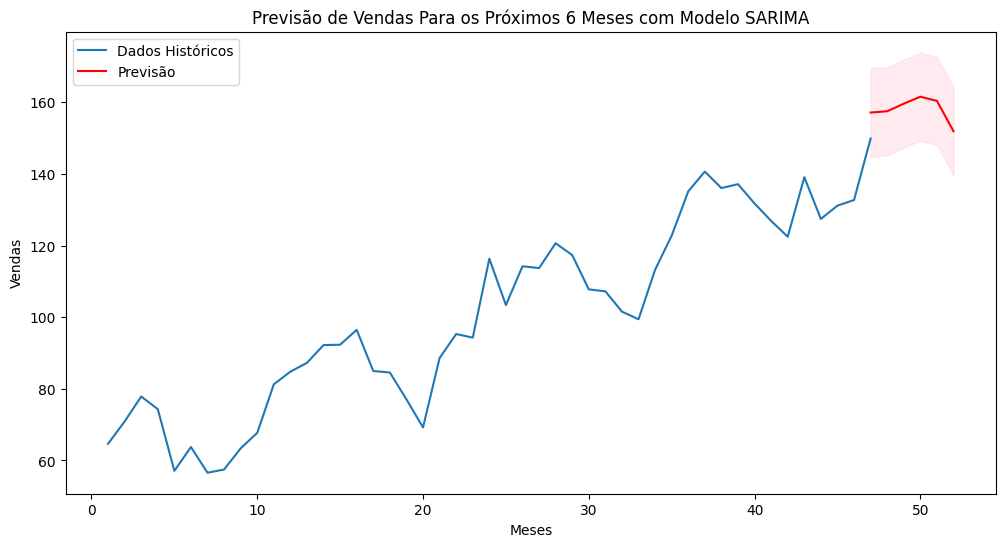

In [37]:
# Plotando os dados históricos
plt.figure(figsize = (12, 6))
plt.plot(df_dsa['vendas'], label = 'Dados Históricos')

# Plotando as previsões
eixo_x_futuro = np.arange(len(df_dsa['vendas']), len(df_dsa['vendas']) + 6)
plt.plot(eixo_x_futuro, previsao_media, label = 'Previsão', color = 'red')

# Plotando os intervalos de confiança
plt.fill_between(eixo_x_futuro, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color = 'pink', alpha = 0.3)

# Labels
plt.title('Previsão de Vendas Para os Próximos 6 Meses com Modelo SARIMA')
plt.xlabel('Meses')
plt.ylabel('Vendas')
plt.legend(loc = 'upper left')
plt.show()

# Fim